# RetailPredict: Forecasting Sales with LightGBM

# Business Problem

- **The goal is to predict product demand at the store-item level for the next 3 months. This helps optimize inventory management and minimize stock-outs or overstock situations.**

# File descriptions

- train.csv - Training data
- test.csv - Test data (Note: the Public/Private split is time based)

#  Data fields

- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

In [81]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from lightgbm import early_stopping, log_evaluation

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [171]:
train = pd.read_csv("/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/Time Series/demand_forecasting_project_ML/data/train.csv", parse_dates=["date"])
test = pd.read_csv("/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/Time Series/demand_forecasting_project_ML/data/test.csv", parse_dates=["date"])

In [172]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [173]:
df = pd.concat([train, test], sort=False)

# EDA

In [14]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [86]:
print("MAX: " + str(df["date"].max()), "MIN: " + str(df["date"].min()))

MAX: 2018-03-31 00:00:00 MIN: 2013-01-01 00:00:00


In [87]:
df["store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [88]:
df["item"].value_counts().head()

item
1     19160
38    19160
28    19160
29    19160
30    19160
Name: count, dtype: int64

In [89]:
df.groupby("store").agg({"sales": ["sum", "mean", "count"]})

sales                  
             sum       mean  count
store                             
1      4315603.0  47.268379  91300
2      6120128.0  67.033165  91300
3      5435144.0  59.530602  91300
4      5012639.0  54.902946  91300
5      3631016.0  39.770164  91300
6      3627670.0  39.733516  91300
7      3320009.0  36.363735  91300
8      5856169.0  64.142048  91300
9      5025976.0  55.049025  91300
10     5360158.0  58.709288  91300

In [174]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "count", "std"]}).head(30)

sales                            
                 sum       mean count        std
store item                                      
1     1      36468.0  19.971522  1826   6.741022
      2      97050.0  53.148959  1826  15.005779
      3      60638.0  33.208105  1826  10.072529
      4      36440.0  19.956188  1826   6.640618
      5      30335.0  16.612815  1826   5.672102
      6      96889.0  53.060789  1826  14.826416
      7      96383.0  52.783680  1826  15.073838
      8     126856.0  69.472070  1826  18.751980
      9      84918.0  46.504929  1826  13.247496
      10    121163.0  66.354326  1826  18.283007
      11    115436.0  63.217963  1826  17.230417
      12    115465.0  63.233844  1826  17.636872
      13    139067.0  76.159365  1826  20.374852
      14     97050.0  53.148959  1826  14.769971
      15    145497.0  79.680723  1826  21.725799
      16     42605.0  23.332421  1826   7.614738
      17     54729.0  29.972070  1826   9.116824
      18    139407.0  76.345564  1826  21.053109
      19     66972.0  36.676889  1826  11.100620
      20     78318.0  42.890471  1826  12.181551
      21     66058.0  36.176342  1826  10.840796
      22    132899.0  72.781490  1826  19.808007
      23     48334.0  26.469880  1826   8.460734
      24    109560.0  60.000000  1826  16.642840
      25    132816.0  72.736035  1826  19.799388
      26     78949.0  43.236035  1826  12.848906
      27     36613.0  20.050931  1826   6.640278
      28    145289.0  79.566813  1826  21.460002
      29    115196.0  63.086528  1826  17.277086
      30     66317.0  36.318182  1826  10.938036

 #  VISUALIZATION

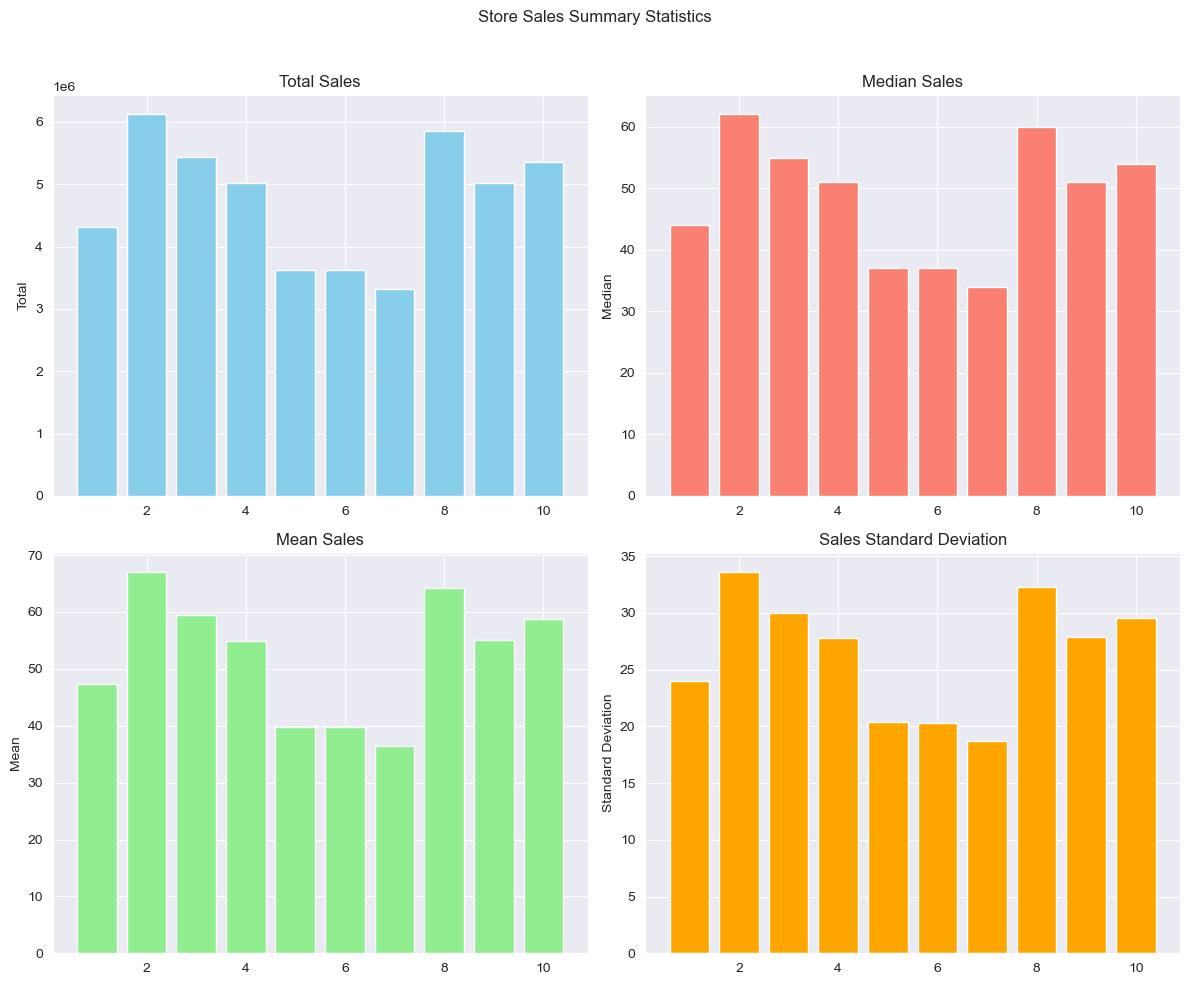

In [91]:
sales_summary = df.groupby("store").agg({"sales": ["sum", "median", "mean", "std"]})
sales_summary.columns = ['sum', 'median', 'mean', 'std']  

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Store Sales Summary Statistics')


axes[0, 0].bar(sales_summary.index, sales_summary['sum'], color='skyblue')
axes[0, 0].set_title('Total Sales')
axes[0, 0].set_ylabel('Total')

axes[0, 1].bar(sales_summary.index, sales_summary['median'], color='salmon')
axes[0, 1].set_title('Median Sales')
axes[0, 1].set_ylabel('Median')

axes[1, 0].bar(sales_summary.index, sales_summary['mean'], color='lightgreen')
axes[1, 0].set_title('Mean Sales')
axes[1, 0].set_ylabel('Mean')

axes[1, 1].bar(sales_summary.index, sales_summary['std'], color='orange')
axes[1, 1].set_title('Sales Standard Deviation')
axes[1, 1].set_ylabel('Standard Deviation')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# FEATURE ENGINEERING

- Date Features

In [92]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [93]:
df = create_date_features(df)

In [94]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [95]:
df.groupby(["store", "month"]).agg({"sales": "sum"})

sales
store month          
1     1      249352.0
      2      250494.0
      3      331214.0
      4      374268.0
      5      414653.0
...               ...
10    8      515431.0
      9      463283.0
      10     446433.0
      11     465091.0
      12     342656.0

[120 rows x 1 columns]

- Lag/Shifted Features

In [96]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [97]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = (dataframe.groupby(["store", "item"])["sales"].
                                                    transform(lambda x: x.shift(lag)) + random_noise(dataframe))
    return dataframe

In [98]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [42]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.831389,53.694324,69.127489,65.651498,68.948585,77.902057,79.509436,60.024091,96.684127,73.636096
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,63.182742,50.131858,67.204001,60.462573,77.017170,81.578736,81.098517,71.860289,78.746566,69.410827
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,63.295310,62.635393,71.820112,68.586453,72.667456,87.469762,79.149995,68.143645,99.217454,74.750443
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.269999,75.101184,69.615824,66.170002,68.858176,82.963137,87.649055,69.696326,78.794606,82.281872
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,63.567485,72.975360,50.344572,69.865637,49.817111,80.435859,103.580268,103.339873,97.682945,82.962225


- Rolling Mean Features

In [99]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])["sales"]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [100]:
df = roll_mean_features(df, [365, 546])

In [101]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.293831,55.250795,69.447155,69.514774,68.786486,81.285409,77.940730,61.644501,94.716461,73.270607,89.454265,86.148798
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.427119,51.535572,70.414032,59.502401,75.066007,80.325794,77.307223,72.198017,80.836497,67.620358,88.908372,86.032479
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,61.354047,59.735871,73.051192,65.870429,74.102918,87.156035,80.563433,70.018762,96.931461,74.285229,87.118592,84.560287
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,71.812090,75.101743,70.901888,65.176557,63.744827,82.007376,90.896649,68.707496,76.196981,84.938485,87.411597,85.017402
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,58.630308,68.724042,52.649065,69.070241,45.951820,80.516412,103.459427,101.398672,94.466993,79.767039,83.544727,86.856954


- Exponentially Weighted Mean Features

In [102]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [103]:
alphas = [0.95, 0.90, 0.80, 0.70, 0.60, 0.50]
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]

In [104]:
df = ewm_features(df, alphas, lags)

In [105]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_06_lag_91,sales_ewm_alpha_06_lag_98,sales_ewm_alpha_06_lag_105,sales_ewm_alpha_06_lag_112,sales_ewm_alpha_06_lag_119,sales_ewm_alpha_06_lag_126,sales_ewm_alpha_06_lag_182,sales_ewm_alpha_06_lag_364,sales_ewm_alpha_06_lag_546,sales_ewm_alpha_06_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.293831,55.250795,69.447155,69.514774,68.786486,81.285409,77.940730,61.644501,94.716461,73.270607,89.454265,86.148798,41.561777,54.028375,66.387487,67.349358,68.440646,80.116347,78.289747,60.337210,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,69.045354,79.370493,77.757904,60.747330,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,70.646302,78.318176,77.220469,61.771911,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,72.608823,77.878621,77.356120,63.027108,87.248414,69.116907,48.582111,57.190804,64.121542,64.613118,74.748837,78.053907,78.095788,64.430865,86.034404,68.861543,51.309755,58.648702,64.033868,64.335072,76.889157,78.812122,79.314746,65.867479,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.427119,51.535572,70.414032,59.502401,75.066007,80.325794,77.307223,72.198017,80.836497,67.620358,88.908372,86.032479,61.928089,51.151419,66.969374,60.367468,75.622032,80.955817,79.914487,72.366861,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,75.304535,80.837049,79.775790,71.774733,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,74.929260,80.463635,79.444094,70.754382,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,74.982647,80.063586,79.206836,70.008132,82.174524,68.335072,57.232844,53.476322,65.848617,61.845247,75.499535,79.821563,79.238315,69.572346,82.413762,68.344617,57.154878,54.824351,65.516934,62.167536,76.444579,79.906061,79.657373,69.433740,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,61.354047,59.735871,73.051192,65.870429,74.102918,87.156035,80.563433,70.018762,96.931461,74.285229,87.118592,84.560287,59.146404,62.407571,71.748469,65.718373,73.131102,86.697791,81.895724,68.218343,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,73.230454,86.383705,81.777579,68.377473,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,73.385852,85.692727,81.488819,68.550876,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,73.5

In [106]:
df.shape

(958000, 86)

- One - Hot Encoding

In [107]:
df = pd.get_dummies(df, columns=["month", "item", "store", "day_of_week"])

In [108]:
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

In [54]:
df.tail()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_06_lag_91,sales_ewm_alpha_06_lag_98,sales_ewm_alpha_06_lag_105,sales_ewm_alpha_06_lag_112,sales_ewm_alpha_06_lag_119,sales_ewm_alpha_06_lag_126,sales_ewm_alpha_06_lag_182,sales_ewm_alpha_06_lag_364,sales_ewm_alpha_06_lag_546,sales_ewm_alpha_06_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
44995,2018-03-27,NaN,44995.0,27,86,13,2018,0,0,0,38.831389,53.694324,69.127489,65.651498,68.948585,77.902057,79.509436,60.024091,96.684127,73.636096,86.221853,84.809364,41.561777,54.028375,66.387487,67.349358,68.440646,80.116347,78.289747,60.337210,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,69.045354,79.370493,77.757904,60.747330,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,70.646302,78.318176,77.220469,61.771911,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,72.608823,77.878621,77.356120,63.027108,87.248414,69.116907,48.582111,57.190804,64.121542,64.613118,74.748837,78.053907,78.095788,64.430865,86.034404,68.861543,51.309755,58.648702,64.033868,64.335072,76.889157,78.812122,79.314746,65.867479,85.489012,68.933911,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
44996,2018-03-28,NaN,44996.0,28,87,13,2018,0,0,0,63.182742,50.131858,67.204001,60.462573,77.017170,81.578736,81.098517,71.860289,78.746566,69.410827,88.327943,85.742281,61.928089,51.151419,66.969374,60.367468,75.622032,80.955817,79.914487,72.366861,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,75.304535,80.837049,79.775790,71.774733,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,74.929260,80.463635,79.444094,70.754382,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,74.98

- Converting sales to log(1+sales)

In [109]:
df["sales"] = np.log1p(df["sales"].values)

# MODEL

- Custom Cost Function


* MAE: mean absolute error
* MAPE: mean absolute percentage error
* SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [110]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [111]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

- Time-Based Validation Sets

In [112]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [113]:
train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [114]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [115]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


# Since the test set we need to forecast consists of 3 months, we use the last 3 months of the last year in our training set, which closely resembles the test set period, as our validation set. Consequently, the remaining data will inevitably be excluded from use.

- Train set up to the beginning of 2017 (until the end of 2016).

In [116]:
train = df.loc[(df["date"] < "2017-01-01"), :]

In [117]:
train.tail()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_06_lag_91,sales_ewm_alpha_06_lag_98,sales_ewm_alpha_06_lag_105,sales_ewm_alpha_06_lag_112,sales_ewm_alpha_06_lag_119,sales_ewm_alpha_06_lag_126,sales_ewm_alpha_06_lag_182,sales_ewm_alpha_06_lag_364,sales_ewm_alpha_06_lag_546,sales_ewm_alpha_06_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
912630,2016-12-27,4.110874,NaN,27,362,52,2016,0,0,0,96.685281,72.643219,82.055577,67.311442,84.530841,81.761654,88.660540,47.287026,77.312161,45.439668,89.364038,77.321393,94.617783,73.997139,80.222461,67.638294,84.268392,80.631341,86.198487,44.889151,75.703727,43.582799,92.561560,74.087153,79.680257,67.545702,84.666248,80.420508,85.597759,44.862423,75.609567,43.331764,89.361543,74.535926,79.248027,68.115069,85.795334,80.441527,85.018610,45.087071,75.991345,43.323382,87.248414,75.315546,79.592225,69.581665,87.248313,80.999724,85.287253,45.701992,77.058762,43.940837,86.034404,76.365991,80.570951,71.785516,88.839168,82.031304,86.384109,46.692735,78.697378,45.101171,85.489012,77.5936,81.980795,74.541716,90.339649,83.475049,88.214020,47.990644,80.759065,46.658305,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
912631,2016-12-28,3.784190,NaN,28,363,52,2016,0,0,0,82.984902,80.768721,69.849574,81.509214,81.470659,91.335819,79.467294,48.940335,82.606026,42.339778,85.419474,79.576344,80.730889,78.749857,70.511123,80.331915,81.163420,89.531567,80.309924,50.694458,82.635186,40.179140,81.256156,78.508715,70.968026,79.654570,81.366625,89.042051,80.559776,50.386242,82.260957,40.333176,81.872309,78.107185,71.849605,78.423014,81.959067,88.088305,81.003722,49.817414,81.598269,40.664676,82.174524,77.894664,72.877667,77.574499,8

- The first 3 months of 2017 as the validation set.

In [132]:
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [133]:
val.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_06_lag_91,sales_ewm_alpha_06_lag_98,sales_ewm_alpha_06_lag_105,sales_ewm_alpha_06_lag_112,sales_ewm_alpha_06_lag_119,sales_ewm_alpha_06_lag_126,sales_ewm_alpha_06_lag_182,sales_ewm_alpha_06_lag_364,sales_ewm_alpha_06_lag_546,sales_ewm_alpha_06_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1461,2017-01-01,2.995732,NaN,1,1,52,2017,1,1,0,25.476808,23.640894,27.529423,22.266571,26.391724,35.099413,37.242193,12.283158,30.026963,13.811936,25.573117,22.420203,25.945616,26.945124,26.600120,24.052691,25.272243,33.501591,34.872876,12.069605,30.474469,14.106506,25.884810,26.880977,26.200950,24.111103,25.487872,33.003412,34.783029,12.176663,30.895524,14.222089,25.755581,26.727186,25.408003,24.243376,25.741670,31.996973,34.664905,12.489886,31.560936,14.457248,25.626387,26.540456,24.631135,24.388848,25.744322,30.971512,34.548034,12.904218,31.960188,14.659810,25.493406,26.315149,23.890485,24.540105,25.481778,29.929221,34.342914,13.366982,32.059872,14.786790,25.336195,26.033001,23.224180,24.695000,24.959972,28.876437,33.973134,13.807964,31.842915,14.803870,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1462,2017-01-02,2.772589,NaN,2,2,1,2017,0,0,0,22.197340,17.451817,19.720046,24.832630,37.036513,16.456768,19.318031,12.280090,17.729297,10.819699,25.094916,20.696296,20.297281,17.497256,19.380006,24.002635,31.663612,14.975080,18.843644,12.003480,20.523723,14.005325,20.588481,17.988098,19.720095,24.011110,31.348787,15.900341,19.678303,12.017666,21.089552,14.022209,21.151116,18.945437,20.281601,24.048675,30.748334,17.599395,21.332981,12.097977,22.312187,14.091450,21.687916,19.862137,20.689341,24.116654,30.123297,

- We removed the 3 variables we won’t use and our target variable (sales).

In [134]:
cols = [col for col in df.columns if col not in ["sales", "date", "id", "year"]]

In [135]:
x_train = train[cols]
Y_train = train["sales"]

In [136]:
x_val = val[cols]
Y_val = val["sales"]

In [137]:
print("x_train: " + str(x_train.shape), "/", "Y_train: " + str(Y_train.shape), "/", "x_val: " + str(x_val.shape), "/", "Y_val: " + str(Y_val.shape))

x_train: (730500, 157) / Y_train: (730500,) / x_val: (45000, 157) / Y_val: (45000,)


- Time Series Model with LightGBM

In [138]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              #'num_boost_round': 1000,
              #'early_stopping_rounds': 200,
              'nthread': -1}

In [139]:
lgbtrain = lgb.Dataset(data=x_train, label=Y_train, feature_name=cols)

In [140]:
lgbval = lgb.Dataset(data=x_val, label=Y_val, feature_name=cols)

In [141]:
model = lgb.train(
    params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=1000,  # Eğitim için tur sayısı
    feval=lgbm_smape,
    callbacks=[
        early_stopping(stopping_rounds=200),  # Erken durdurma için callback fonksiyonu
        log_evaluation(100)  # Her 100 iterasyonda bir log
    ]
)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0510977	training's SMAPE: 17.5443	valid_1's l2: 0.0520069	valid_1's SMAPE: 17.3184
[200]	training's l2: 0.0353467	training's SMAPE: 14.5938	valid_1's l2: 0.03695	valid_1's SMAPE: 14.8827
[300]	training's l2: 0.0324717	training's SMAPE: 14.0268	valid_1's l2: 0.03423	valid_1's SMAPE: 14.4509
[400]	training's l2: 0.0314359	training's SMAPE: 13.8281	valid_1's l2: 0.0334319	valid_1's SMAPE: 14.3152
[500]	training's l2: 0.0308061	training's SMAPE: 13.7035	valid_1's l2: 0.0328492	valid_1's SMAPE: 14.1933
[600]	training's l2: 0.0303503	training's SMAPE: 13.6084	valid_1's l2: 0.0324116	valid_1's SMAPE: 14.0923
[700]	training's l2: 0.0299983	training's SMAPE: 13.5358	valid_1's l2: 0.0320623	valid_1's SMAPE: 14.0087
[800]	training's l2: 0.0297043	training's SMAPE: 13.4749	valid_1's l2: 0.0317914	valid_1's SMAPE: 13.9418
[900]	training's l2: 0.0294657	training's SMAPE: 13.4249	valid_1's l2: 0.031591	valid_1's SMAP

- predict

In [142]:
y_pred_val = model.predict(x_val, num_iteration=model.best_iteration)

- smape

In [143]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.854948603833511

# FEATURE IMPORTANCE

In [144]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

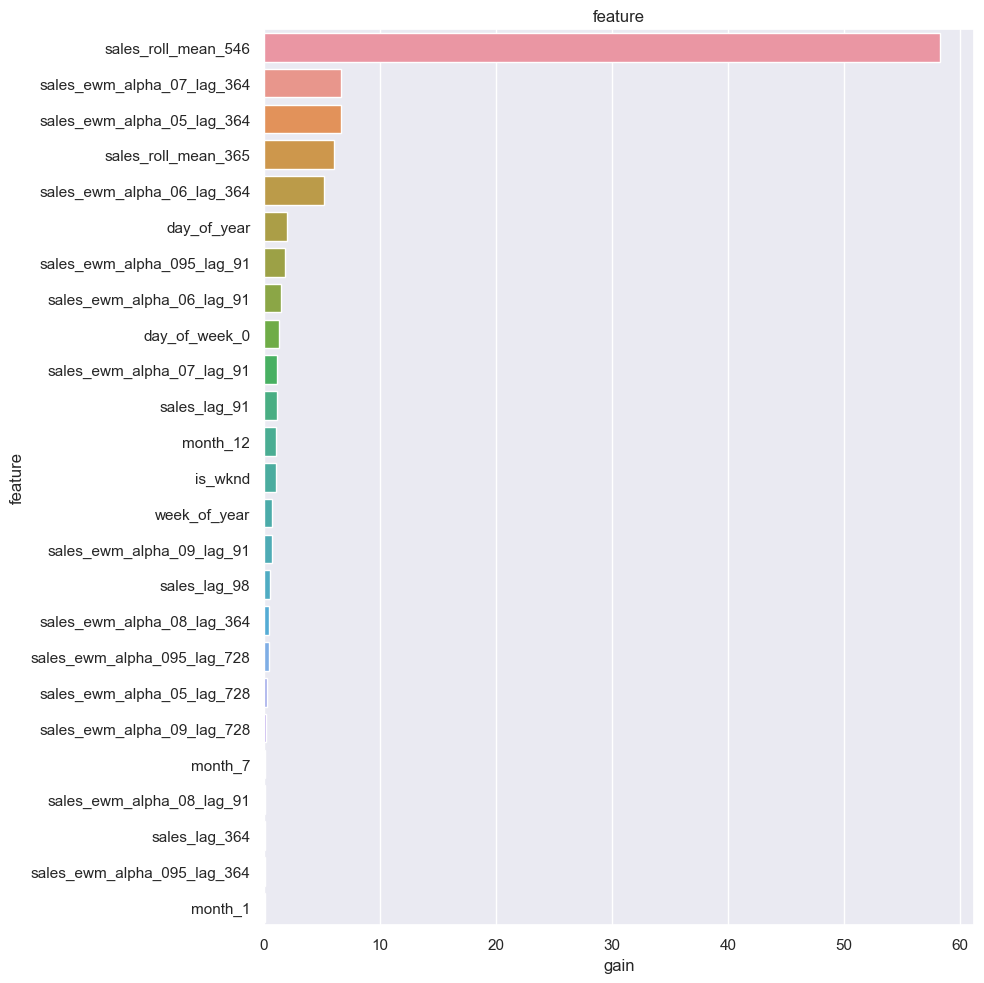

,feature,split,gain
17,sales_roll_mean_546,951,58.287467
55,sales_ewm_alpha_07_lag_364,131,6.680582
75,sales_ewm_alpha_05_lag_364,261,6.656810
16,sales_roll_mean_365,590,6.094675
65,sales_ewm_alpha_06_lag_364,97,5.203643
...,...,...,...
122,item_33,0,0.000000
85,month_8,0,0.000000
124,item_35,0,0.000000
128,item_39,0,0.000000


In [145]:
plot_lgb_importances(model, num=30, plot=True)

- **In the LightGBM model, filter out features with zero importance and create a list of only impactful features. This allows for model improvement with more meaningful features.**

In [146]:
feat_imp = plot_lgb_importances(model, num=200)
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                        feature  split       gain
17          sales_roll_mean_546    951  58.287467
55   sales_ewm_alpha_07_lag_364    131   6.680582
75   sales_ewm_alpha_05_lag_364    261   6.656810
16          sales_roll_mean_365    590   6.094675
65   sales_ewm_alpha_06_lag_364     97   5.203643
..                          ...    ...        ...
122                     item_33      0   0.000000
85                      month_8      0   0.000000
124                     item_35      0   0.000000
128                     item_39      0   0.000000
81                      month_4      0   0.000000

[157 rows x 3 columns]


126

# FINAL MODEL

- final train

In [147]:
train = df.loc[~df.sales.isna()]

In [148]:
x_train = train[cols]
Y_train = train["sales"]

- final test

In [149]:
test = df.loc[df.sales.isna()]

In [150]:
x_test = test[cols]

- final params

In [151]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [152]:
lgbtrainall = lgb.Dataset(data=x_train, label=Y_train, feature_name=cols)

- final model

In [153]:
model = lgb.train(lgb_params, 
                  lgbtrainall, 
                  num_boost_round=model.best_iteration)

- final predictions

In [154]:
test_preds = model.predict(x_test, num_iteration=model.best_iteration)

# Submission File

- I need to create a file containing only the `id` and `predicted_sales` variables.

In [157]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_06_lag_91,sales_ewm_alpha_06_lag_98,sales_ewm_alpha_06_lag_105,sales_ewm_alpha_06_lag_112,sales_ewm_alpha_06_lag_119,sales_ewm_alpha_06_lag_126,sales_ewm_alpha_06_lag_182,sales_ewm_alpha_06_lag_364,sales_ewm_alpha_06_lag_546,sales_ewm_alpha_06_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,12.954757,14.461836,23.561559,19.533237,11.530496,12.871622,21.035912,13.815225,15.847795,12.438731,26.665452,20.695131,12.472220,14.531325,22.392609,16.695005,12.558924,15.578910,18.982132,15.188730,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,13.140759,16.210611,19.927201,15.359645,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,14.395412,17.595555,21.701762,15.673300,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,15.785929,19.069296,23.327313,15.980655,22.964410,12.271265,16.790241,19.309244,24.630397,21.248330,17.294984,20.535933,24.825385,16.298744,24.537165,12.546793,18.192747,20.671654,24.971733,22.381769,18.866422,21.902001,26.218374,16.617438,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,14.513082,20.580648,21.313919,16.469082,26.779494,20.867496,23.188437,12.132892,29.863917,10.761913,22.777269,21.881543,17.723611,17.826566,21.069630,19.834750,25.327946,20.728945,22.799107,10.259436,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,24.714076,20.521061,22.692720,10.535964,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,23.679082,20.319111,22.740352,11.134660,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,22.935779,20.420789,23.0981

- I am extracting the `id` and `sales` variables from the test data.

In [164]:
submissions_df = test.loc[:, ["id", "sales"]]

- After extracting the data, since all `sales` variables in the test set are NaN, I assign my predicted values to the `sales` variable. While doing this, I also revert the values from their log form.

In [165]:
submissions_df["sales"] = np.expm1(test_preds)

- I converted the IDs to integers.

In [167]:
submissions_df.id = submissions_df.id.astype(int)

In [169]:
submissions_df.head()

,id,sales
0,0,12.684991
1,1,13.474513
2,2,13.277390
3,3,14.451798
4,4,17.725461


In [ ]:
submissions_df.to_csv("submission_demand.csv", index=False)

# THANKS.